In [ ]:
!pip3 install keras

In [1]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

import numpy as np

from keras import backend as K
import tensorflow as tf
B = tf.keras.backend

# Load Gelu

@tf.function(experimental_relax_shapes=True)
def gelu(x):
    return 0.5 * x * (1 + B.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


In [2]:
# Hyper Params

batch_size = 64
init_lr = 0.0035
optimizer = keras.optimizers.Adamax()
decay = 0.925
datagen_rate = 4
datagen_rotation = 15
z_score = True
activation_function = gelu
early_stop_patience = 5
reduce_lr_on_plateau_patience = 2
reduce_lr_on_plateau_factor = 0.5

In [3]:
# Load Data

(x_train_init, y_train_init), (x_test_init, y_test_init) = cifar10.load_data()

In [4]:
# Data Prep

x_train = (x_train_init).astype('float32')
x_test = (x_test_init).astype('float32')

if z_score:
    mean = np.mean(x_train,axis=(0,1,2,3))
    std = np.std(x_train,axis=(0,1,2,3))
    x_train = (x_train - mean) / std
    x_test = (x_test - mean) / std
else:
    x_train = x_train / 255.0
    x_test = x_test / 255.0

num_classes = 10
y_train = np_utils.to_categorical(y_train_init,num_classes)
y_test = np_utils.to_categorical(y_test_init,num_classes)


In [5]:
# Model Architecture

model = Sequential()

# First Section - 32
model.add(Conv2D(32, (3,3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation(activation_function))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same'))
model.add(Activation(activation_function))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
# Second Section - 64
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation(activation_function))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation(activation_function))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
# Third Section - 128
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation(activation_function))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation(activation_function))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.35))
 
# Final dense and Softmax
model.add(Flatten())
model.add(Dense(units=256, activation=activation_function))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [6]:
# Callbacks

def lr_schedule(epoch):
    lrate = init_lr
    if epoch > 9:
        lrate = 0.0025
    if epoch > 19:
        lrate = 0.0015
    if epoch > 29:
        lrate = 0.0075
    if epoch > 44:
        lrate = 0.0035
    return lrate

def lr_decay(epoch):
    return init_lr * decay ** epoch

class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))
        
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=early_stop_patience, restore_best_weights=True)

reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=reduce_lr_on_plateau_patience, verbose=1, mode='min')

In [7]:
# TF Datagen

datagen = ImageDataGenerator(
    rotation_range=datagen_rotation,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [8]:
# Train

model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=x_train.shape[0] * datagen_rate // batch_size,
          epochs=100,
          validation_data=(x_test,y_test),
          callbacks=[
              LearningRateScheduler(lr_decay),
              LrHistory(),
              reduce_lr_loss,
              early_stop
          ])

# Save Model
model.save('cifar_model')

Learning rate: 0.0035
Epoch 1/100
3125/3125 [==============================] - 148s 48ms/step - loss: 1.4642 - accuracy: 0.4800 - val_loss: 1.0058 - val_accuracy: 0.6440 - lr: 0.0035
Learning rate: 0.0032375
Epoch 2/100
3125/3125 [==============================] - 149s 48ms/step - loss: 0.9245 - accuracy: 0.6825 - val_loss: 0.7107 - val_accuracy: 0.7598 - lr: 0.0032
Learning rate: 0.0029946875
Epoch 3/100
3125/3125 [==============================] - 144s 46ms/step - loss: 0.7550 - accuracy: 0.7435 - val_loss: 0.7076 - val_accuracy: 0.7686 - lr: 0.0030
Learning rate: 0.002770086
Epoch 4/100
3125/3125 [==============================] - 142s 46ms/step - loss: 0.6622 - accuracy: 0.7760 - val_loss: 0.5355 - val_accuracy: 0.8189 - lr: 0.0028
Learning rate: 0.0025623294
Epoch 5/100
3125/3125 [==============================] - 146s 47ms/step - loss: 0.5978 - accuracy: 0.7974 - val_loss: 0.5836 - val_accuracy: 0.8080 - lr: 0.0026
Learning rate: 0.0023701547
Epoch 6/100
3125/3125 [==============

In [9]:
# Test Model
scores = model.evaluate(x_test, y_test, batch_size=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 70s 7ms/step - loss: 0.3453 - accuracy: 0.8929

Test result: 89.290 loss: 0.345


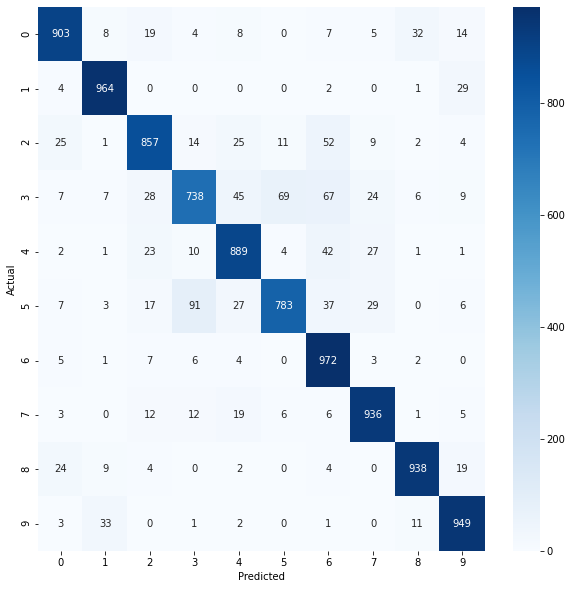

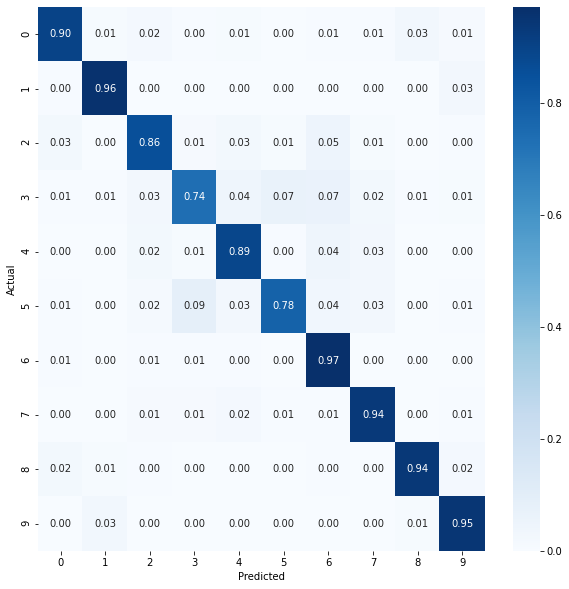

In [31]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
Y_pred = model.predict(x_test)
y_test_non_category = [ np.argmax(t) for t in y_test ]
y_predict_non_category = [ np.argmax(t) for t in Y_pred ]
conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)
cnf_matrix_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]


fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='0', cmap=plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cnf_matrix_norm, annot=True, fmt='.2f', cmap=plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
